In [1]:
ls /mnt/data/decathlon

Task01_BrainTumour/     Task04_Hippocampus.tar  Task08_HepaticVessel/
Task01_BrainTumour.tar  Task05_Prostate/        Task08_HepaticVessel.tar
Task02_Heart/           Task05_Prostate.tar     Task09_Spleen/
Task02_Heart.tar        Task06_Lung/            Task09_Spleen.tar
Task03_Liver/           Task06_Lung.tar         Task10_Colon/
Task03_Liver.tar        Task07_Pancreas/        Task10_Colon.tar
Task04_Hippocampus/     Task07_Pancreas.tar


In [7]:
!tar -C /mnt/data/decathlon -xf /mnt/data/decathlon/Task01_BrainTumour.tar
!tar -C /mnt/data/decathlon -xf /mnt/data/decathlon/Task02_Heart.tar
!tar -C /mnt/data/decathlon -xf /mnt/data/decathlon/Task03_Liver.tar
!tar -C /mnt/data/decathlon -xf /mnt/data/decathlon/Task04_Hippocampus.tar
!tar -C /mnt/data/decathlon -xf /mnt/data/decathlon/Task05_Prostate.tar

In [63]:
!tar -C /mnt/data/decathlon -xf /mnt/data/decathlon/Task06_Lung.tar
!tar -C /mnt/data/decathlon -xf /mnt/data/decathlon/Task07_Pancreas.tar
!tar -C /mnt/data/decathlon -xf /mnt/data/decathlon/Task08_HepaticVessel.tar
!tar -C /mnt/data/decathlon -xf /mnt/data/decathlon/Task09_Spleen.tar
!tar -C /mnt/data/decathlon -xf /mnt/data/decathlon/Task10_Colon.tar

In [1]:
from univread import read as imread
from glob import glob
import os
from medpy.io import load as medload
from tqdm.auto import tqdm
import numpy as np

In [2]:
tasks = glob('/mnt/data/decathlon/*/')
good_tasks = tasks[:3] + tasks[6:8]
good_tasks

['/mnt/data/decathlon/Task01_BrainTumour/',
 '/mnt/data/decathlon/Task02_Heart/',
 '/mnt/data/decathlon/Task03_Liver/',
 '/mnt/data/decathlon/Task07_Pancreas/',
 '/mnt/data/decathlon/Task08_HepaticVessel/']

In [2]:
from skimage.exposure import rescale_intensity

In [3]:
def preprocess_img(img):
    if len(img.shape) == 4:
        nimg = []
        for m in range(img.shape[-1]):
            inr = (np.percentile(img[..., m], 1), np.percentile(img[..., m], 99))
            nimg.append(rescale_intensity(img[..., m], in_range=inr, out_range=(0, 255)))
        return np.stack(nimg).mean(0).astype(np.uint8)
    else:
        inr = (np.percentile(img, 1), np.percentile(img, 99))
        return rescale_intensity(img, in_range=inr, out_range=(0, 255)).astype(np.uint8)

In [4]:
def subsample_dataset(markup, step):
    offset_qualities = []
    for offset in range(step):
        offset_qualities.append(markup[offset::step].sum())
    best_offset = np.argmax(np.array(offset_qualities))
    slices = np.zeros(len(markup))
    slices[best_offset::step] = 1
    slices[markup.sum((1,2))==0] = -1
    is_marked = np.where(markup.sum((1,2)) > 0)[0]
    slices[is_marked[0]] = 1
    slices[is_marked[-1]] = 1
    return slices

In [4]:
def subsample_dataset_v2(markup, step):
    offset_qualities = []
    for offset in range(step):
        offset_qualities.append(markup[offset::step].sum())
    best_offset = np.argmax(np.array(offset_qualities))
    slices = np.zeros(len(markup))
    slices[best_offset::step] = 1
    slices[markup.sum((1,2))==0] = -1
    is_marked = np.where(markup.sum((1,2)) > 0)[0]
    slices[is_marked[0]] = 1
    slices[is_marked[-1]] = 1
    return slices

In [5]:
def get_subsampled_dataset(lbl, step):
    sus = subsample_dataset(lbl, step)
    slbl = (lbl > 0) * sus[:, None, None]
    return slbl

In [93]:
def get_subsampled_dataset_v2(lbl, step):
    sus = subsample_dataset(lbl, step)
    slbl = lbl * sus[:, None, None]
    return slbl

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
def get_sparsedense_labels(lbl, slbl, img):
    is_originally_labeled = lbl.sum((1, 2)) > 0
    is_sparsely_labeled = slbl.sum((1, 2)) > 0
    
    selector = ~is_originally_labeled | is_sparsely_labeled
    
    return slbl[selector], img[selector]

In [8]:
from scipy.interpolate import LinearNDInterpolator, griddata

In [9]:
bbox_to_slices = lambda ends, offsets: tuple([slice(o, e) for e,o in zip(ends, offsets)])

In [10]:
def complicated_interpolation(slbl):
    sus = (slbl.sum((1, 2)) > 0)
    
    bbox_end = (np.where(slbl.sum((1,2))>0)[0][-1], 
                 np.where(slbl.sum((0,2))>0)[0][-1], 
                 np.where(slbl.sum((1,0))>0)[0][-1])
    bbox_offset = (np.where(slbl.sum((1,2))>0)[0][0], 
                   np.where(slbl.sum((0,2))>0)[0][0], 
                   np.where(slbl.sum((1,0))>0)[0][0])

    slbl_in_bb = slbl[bbox_to_slices(bbox_end, bbox_offset)]

    whole_set = np.meshgrid(*[np.arange(i) for i in slbl_in_bb.shape])
    whole_set = np.stack(whole_set).reshape(3, -1).T

    lines_selected = np.arange(bbox_end[0]-bbox_offset[0])[sus[bbox_offset[0]:bbox_end[0]]==1]
    slices_selected = whole_set[np.isin(whole_set[:, 0], lines_selected)]
    values_selected = slbl_in_bb[tuple(slices_selected.T)]

    prediction = griddata(slices_selected, values_selected, whole_set, method='nearest')
    
    slbl_in_bb_pred = np.zeros_like(slbl_in_bb)
    slbl_in_bb_pred[tuple(whole_set.T)] = prediction
    
    slbl_pred = np.zeros_like(slbl)
    slbl_pred[bbox_to_slices(bbox_end, bbox_offset)] = slbl_in_bb_pred
    return slbl_pred

In [11]:
import sys, tifffile

In [13]:
sys.path.append('../biomedisa/')
os.environ['PATH'] = '/usr/local/cuda-11.5/bin/:'+os.environ['PATH']
os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda-11.5/lib64/'
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

In [14]:
from demo.biomedisa_interpolation import process_one_volume

In [15]:
def interpolate_with_biomedisa(img, lbl, res_addr):
    img_f = tempfile.NamedTemporaryFile(suffix='.tiff')
    lbl_f = tempfile.NamedTemporaryFile(suffix='.tiff')
    
    tifffile.imwrite(img_f, img)
    tifffile.imwrite(lbl_f, lbl)
    
    process_one_volume(img_f.name, lbl_f.name, res_addr)
    
    img_f.close()
    lbl_f.close()

## Decathlon itself

In [16]:
slice_spaces = {'/mnt/data/decathlon/Task01_BrainTumour/': 10, 
                '/mnt/data/decathlon/Task02_Heart/': 10, 
                '/mnt/data/decathlon/Task03_Liver/': 10, 
                '/mnt/data/decathlon/Task07_Pancreas/': 5, 
                '/mnt/data/decathlon/Task08_HepaticVessel/': 5}

In [196]:
for task_addr in tqdm(good_tasks):
    file_names = [os.path.basename(fn) for fn in glob(os.path.join(task_addr, 'imagesTr', '*'))]
    train_filenames, test_filenames = train_test_split(file_names, test_size=0.2, random_state=42)
    
#     # REMOVE THIS LINE AFTER TESTING!!!
#     train_filenames = train_filenames[:5]
#     test_filenames = test_filenames[:5]
#     # END OF TESTING SETUP!!!
    
    test_images = os.path.join(task_addr, 'test', 'volumes')
    test_labels = os.path.join(task_addr, 'test', 'labels')
    
    os.makedirs(test_images, exist_ok=True)
    os.makedirs(test_labels, exist_ok=True)
    
    for fn in tqdm(test_filenames, leave=False):
        sn = fn.split('.')[0]
        sn = f'{sn}.tif'
        
        img = imread(os.path.join(task_addr, 'imagesTr', fn))
        img = preprocess_img(img)
        img = np.moveaxis(img, -1, 0)
        tifffile.imsave(os.path.join(test_images, sn), img)
        
        lbl = imread(os.path.join(task_addr, 'labelsTr', fn))
        lbl = (lbl > 0).astype(np.uint8)
        lbl = np.moveaxis(lbl, -1, 0)
        tifffile.imsave(os.path.join(test_labels, sn), lbl)
    
    train_images = os.path.join(task_addr, 'train', 'volumes')
    train_labels_original = os.path.join(task_addr, 'train', 'labels')
    train_labels_sparse = os.path.join(task_addr, 'train', 'labels_sparse')
    train_images_sparse = os.path.join(task_addr, 'train', 'images_sparse')
    train_labels_nearest = os.path.join(task_addr, 'train', 'labels_nearest')
    train_labels_biomedisa = os.path.join(task_addr, 'train', 'labels_biomedisa')
    
    os.makedirs(train_images, exist_ok=True)
    os.makedirs(train_labels_original, exist_ok=True)
    os.makedirs(train_labels_sparse, exist_ok=True)
    os.makedirs(train_images_sparse, exist_ok=True)
    os.makedirs(train_labels_nearest, exist_ok=True)
    os.makedirs(train_labels_biomedisa, exist_ok=True)
    
    for fn in tqdm(train_filenames, leave=False):
        sn = fn.split('.')[0]
        sn = f'{sn}.tif'
        
        img = imread(os.path.join(task_addr, 'imagesTr', fn))
        img = preprocess_img(img)
        img = np.moveaxis(img, -1, 0)
        tifffile.imsave(os.path.join(train_images, sn), img)
        
        lbl = imread(os.path.join(task_addr, 'labelsTr', fn))
        lbl = (lbl > 0).astype(np.uint8)
        lbl = np.moveaxis(lbl, -1, 0)
        tifffile.imsave(os.path.join(train_labels_original, sn), lbl)
        
        slbl = get_subsampled_dataset(lbl, slice_spaces[task_addr])
        
        # make the sparse labels
        sdlbl, sdimg = get_sparsedense_labels(lbl, slbl, img)
        
        tifffile.imsave(os.path.join(train_labels_sparse, sn), sdlbl.astype(np.uint8))
        tifffile.imsave(os.path.join(train_images_sparse, sn), sdimg.astype(np.uint8))
        
        # make the linearly interpolated labels
        llbl = complicated_interpolation(slbl)
        
        tifffile.imsave(os.path.join(train_labels_nearest, sn), llbl.astype(np.uint8))
        
        # make biomedisa interpolated labels
        blbl = interpolate_with_biomedisa(img, slbl, os.path.join(train_labels_biomedisa, sn))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

ips-deepl 0
Indices: [[52, 60, 70, 80, 90, 100, 110, 117]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 7 seconds
Computation time: 7 sec
ips-deepl 0
Indices: [[47, 53, 63, 73, 83, 93, 103, 113, 123, 133, 138]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 9 seconds
Computation time: 9 sec
ips-deepl 0
Indices: [[33, 41, 51, 61, 71, 81, 91, 101, 104]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 5 seconds
Computation time: 5 sec
ips-deepl 0
Indices: [[38, 43, 53, 63, 73, 83, 93, 103, 113]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 8 seconds
Computation time: 9 sec
ips-deepl 0
Indices: [[12, 14, 24, 34, 44, 54, 64, 74, 84, 94, 104, 114, 124, 126]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 10 seconds
Computation time: 11 sec
ips-deepl 0
Indices: [[67, 81, 91, 101, 111, 121, 127]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 5 seconds
Computation time: 5 sec
ips-deepl 0
Indices: [[36, 40, 50, 60, 70, 80, 83]]
ips-deepl 

Computation time: 10 sec
ips-deepl 0
Indices: [[49, 55, 65, 75, 85, 95, 105, 115, 125, 131]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 9 seconds
Computation time: 10 sec
ips-deepl 0
Indices: [[85, 86, 96, 106, 116, 126, 131]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 4 seconds
Computation time: 5 sec
ips-deepl 0
Indices: [[40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 134]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 10 seconds
Computation time: 10 sec
ips-deepl 0
Indices: [[63, 71, 81, 91, 101, 111, 117]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 5 seconds
Computation time: 6 sec
ips-deepl 0
Indices: [[72, 75, 85, 95, 105, 109]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 3 seconds
Computation time: 3 sec
ips-deepl 0
Indices: [[57, 61, 71, 81, 91, 101, 111, 121, 131, 138]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 9 seconds
Computation time: 9 sec
ips-deepl 0
Indices: [[31, 33, 43, 53, 63, 73, 83, 87]]
ips-d

ips-deepl 0: 2/2
Walktime_ips-deepl 0: 5 seconds
Computation time: 6 sec
ips-deepl 0
Indices: [[34, 41, 51, 61, 71, 81, 90]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 4 seconds
Computation time: 5 sec
ips-deepl 0
Indices: [[31, 41, 51, 61, 71, 81, 91]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 5 seconds
Computation time: 5 sec
ips-deepl 0
Indices: [[50, 52, 62, 72, 82, 92, 102, 112, 122, 129]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 6 seconds
Computation time: 7 sec
ips-deepl 0
Indices: [[52, 61, 71, 81, 91, 101, 111, 121, 131, 135]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 8 seconds
Computation time: 9 sec
ips-deepl 0
Indices: [[30, 37, 47, 57, 67, 77, 87]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 4 seconds
Computation time: 4 sec
ips-deepl 0
Indices: [[40, 46, 56, 66, 76, 86, 90]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 3 seconds
Computation time: 4 sec
ips-deepl 0
Indices: [[29, 38, 48, 58, 68,

Computation time: 4 sec
ips-deepl 0
Indices: [[27, 31, 41, 51, 61, 71, 81, 91]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 5 seconds
Computation time: 6 sec
ips-deepl 0
Indices: [[49, 57, 67, 77, 87, 97, 104]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 6 seconds
Computation time: 6 sec
ips-deepl 0
Indices: [[24, 30, 40, 50, 60, 70, 80, 90, 100]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 7 seconds
Computation time: 8 sec
ips-deepl 0
Indices: [[38, 40, 50, 60, 70, 80, 90, 100, 110, 113]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 7 seconds
Computation time: 8 sec
ips-deepl 0
Indices: [[56, 58, 68, 78, 88, 98, 108, 117]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 7 seconds
Computation time: 8 sec
ips-deepl 0
Indices: [[27, 37, 47, 57, 67, 77, 87, 97, 107, 115]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 8 seconds
Computation time: 9 sec
ips-deepl 0
Indices: [[38, 41, 51, 61, 71, 81, 91, 101, 105]]
ips-deepl 0: 

ips-deepl 0
Indices: [[89, 94, 104, 114, 124, 132]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 3 seconds
Computation time: 3 sec
ips-deepl 0
Indices: [[49, 51, 61, 71, 81, 91, 101, 105]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 5 seconds
Computation time: 6 sec
ips-deepl 0
Indices: [[50, 53, 63, 73, 83, 93, 103, 111]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 5 seconds
Computation time: 6 sec
ips-deepl 0
Indices: [[31, 36, 46, 56, 66, 71]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 3 seconds
Computation time: 4 sec
ips-deepl 0
Indices: [[43, 45, 55, 65, 69]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 2 seconds
Computation time: 3 sec
ips-deepl 0
Indices: [[48, 53, 63, 73, 83, 93, 103, 113, 123, 133, 136]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 10 seconds
Computation time: 10 sec
ips-deepl 0
Indices: [[48, 54, 64, 74, 84, 94, 104, 114, 124, 132]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 9

ips-deepl 0: 2/2
Walktime_ips-deepl 0: 6 seconds
Computation time: 7 sec
ips-deepl 0
Indices: [[75, 83, 93, 103, 113, 123, 133, 140]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 6 seconds
Computation time: 7 sec
ips-deepl 0
Indices: [[62, 67, 77, 87, 97, 107, 117, 127, 137, 143]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 9 seconds
Computation time: 9 sec
ips-deepl 0
Indices: [[60, 65, 75, 85, 95, 105, 115, 125, 135, 140]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 8 seconds
Computation time: 8 sec
ips-deepl 0
Indices: [[34, 39, 49, 59, 69, 79, 89, 99, 109, 119, 123]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 9 seconds
Computation time: 9 sec
ips-deepl 0
Indices: [[30, 33, 53, 63, 73, 83, 93, 103, 109]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 6 seconds
Computation time: 6 sec
ips-deepl 0
Indices: [[35, 42, 52, 62, 72, 82, 92, 102, 112, 122, 128]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 9 seconds
Computa

ips-deepl 0: 2/2
Walktime_ips-deepl 0: 4 seconds
Computation time: 5 sec
ips-deepl 0
Indices: [[54, 55, 65, 75, 85, 95, 105, 115, 125, 130]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 7 seconds
Computation time: 8 sec
ips-deepl 0
Indices: [[47, 52, 62, 72, 82, 92, 102, 112, 122, 130]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 9 seconds
Computation time: 10 sec
ips-deepl 0
Indices: [[32, 33, 43, 53, 63, 73, 83, 93, 103, 113, 123, 125]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 10 seconds
Computation time: 11 sec
ips-deepl 0
Indices: [[44, 52, 62, 72, 82, 92, 102, 112, 122, 129]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 9 seconds
Computation time: 9 sec
ips-deepl 0
Indices: [[37, 47, 57, 67, 77, 87, 97, 101]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 5 seconds
Computation time: 6 sec
ips-deepl 0
Indices: [[36, 41, 51, 61, 71, 81, 91, 101, 111, 121, 130]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 9 seconds

ips-deepl 0: 2/2
Walktime_ips-deepl 0: 6 seconds
Computation time: 7 sec
ips-deepl 0
Indices: [[31, 38, 48, 58, 68, 78, 88, 98, 101]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 7 seconds
Computation time: 7 sec
ips-deepl 0
Indices: [[38, 46, 56, 66, 76, 86, 96, 106, 116, 126, 135]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 10 seconds
Computation time: 10 sec
ips-deepl 0
Indices: [[73, 75, 85, 95, 105, 115, 125, 133]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 4 seconds
Computation time: 4 sec
ips-deepl 0
Indices: [[40, 47, 57, 67, 77, 87, 97, 107, 115]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 8 seconds
Computation time: 9 sec
ips-deepl 0
Indices: [[60, 64, 74, 84, 94, 104, 114, 124, 127]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 6 seconds
Computation time: 7 sec
ips-deepl 0
Indices: [[59, 67, 77, 87, 97, 107, 117, 127, 137, 140]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 7 seconds
Computation time: 8 s

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

ips-deepl 0
Indices: [[46, 47, 57, 67, 77, 87, 97, 107, 111]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 7 seconds
Computation time: 8 sec
ips-deepl 0
Indices: [[44, 54, 64, 74, 84, 94, 104, 107]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 5 seconds
Computation time: 6 sec
ips-deepl 0
Indices: [[47, 52, 62, 72, 82, 92, 102, 104]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 5 seconds
Computation time: 6 sec
ips-deepl 0
Indices: [[41, 48, 58, 68, 78, 88, 98, 108, 114]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 7 seconds
Computation time: 7 sec
ips-deepl 0
Indices: [[41, 45, 55, 65, 75, 85, 95, 99]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 6 seconds
Computation time: 7 sec
ips-deepl 0
Indices: [[7, 12, 22, 32, 42, 52, 62, 68]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 5 seconds
Computation time: 5 sec
ips-deepl 0
Indices: [[38, 45, 55, 65, 75, 85, 95, 105]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

ips-deepl 0
Indices: [[92, 99, 109, 119, 129, 139, 149, 155]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 38 seconds
Computation time: 42 sec
ips-deepl 0
Indices: [[61, 62, 72, 82, 92, 97]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 13 seconds
Computation time: 14 sec
ips-deepl 0
Indices: [[100, 104, 114, 124, 134, 144, 154, 164, 174, 184, 194, 204, 214, 224, 234, 238]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 63 seconds
Computation time: 1 min 10 sec
ips-deepl 0
Indices: [[5, 7, 17, 27, 37, 47, 57, 67, 77, 87, 97, 107, 108]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 42 seconds
Computation time: 43 sec
ips-deepl 0
Indices: [[100, 109, 119, 129, 139, 149, 159, 169, 176]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 28 seconds
Computation time: 31 sec
ips-deepl 0
Indices: [[13, 20, 30, 40, 50, 60, 70, 71]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 25 seconds
Computation time: 26 sec
ips-deepl 0
Indices: [[47, 

ips-deepl 0: 2/2
Walktime_ips-deepl 0: 108 seconds
Computation time: 2 min 0 sec
ips-deepl 0
Indices: [[23, 25, 35, 45, 55, 65, 75, 85, 95, 105, 115, 121]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 40 seconds
Computation time: 42 sec
ips-deepl 0
Indices: [[29, 33, 43, 53, 63, 69]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 20 seconds
Computation time: 22 sec
ips-deepl 0
Indices: [[100, 106, 116, 126, 136, 146, 156, 166, 176, 186, 196, 206, 216, 226, 236, 246, 256, 266, 276, 286, 296, 304]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 106 seconds
Computation time: 1 min 56 sec
ips-deepl 0
Indices: [[100, 109, 119, 129, 139, 149, 159, 169, 179, 189, 199, 209, 219, 229, 239, 249, 259, 269, 279, 289, 299, 309, 319, 329, 339, 349, 359, 369, 379, 389, 398]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 140 seconds
Computation time: 2 min 30 sec
ips-deepl 0
Indices: [[69, 70, 80, 90, 100]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 

ips-deepl 0
Indices: [[100, 105, 115, 125, 135, 145, 155, 165, 175, 185, 195, 205, 215, 225, 235, 245, 255, 265, 275, 285, 295, 305, 315, 325, 335, 345, 349]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 136 seconds
Computation time: 2 min 27 sec
ips-deepl 0
Indices: [[100, 103, 113, 123, 133, 143, 153, 163, 173, 183, 193, 195]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 41 seconds
Computation time: 44 sec
ips-deepl 0
Indices: [[34, 41, 51, 61, 71, 81, 91, 101, 111, 121, 129]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 37 seconds
Computation time: 39 sec
ips-deepl 0
Indices: [[83, 90, 100, 110, 120, 130, 140, 150, 160, 161]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 30 seconds
Computation time: 32 sec
ips-deepl 0
Indices: [[58, 66, 76, 86, 93]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 9 seconds
Computation time: 11 sec
ips-deepl 0
Indices: [[78, 84, 94, 104, 114, 124, 134, 136]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

ips-deepl 0
Indices: [[13, 14, 19, 24, 29, 34, 39, 43]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 9 seconds
Computation time: 10 sec
ips-deepl 0
Indices: [[32, 37, 42, 47, 52, 57, 61]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 10 seconds
Computation time: 11 sec
ips-deepl 0
Indices: [[23, 26, 31, 36, 41, 42]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 6 seconds
Computation time: 7 sec
ips-deepl 0
Indices: [[30, 33, 38, 43, 48, 53, 54]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 8 seconds
Computation time: 10 sec
ips-deepl 0
Indices: [[9, 14, 19, 24, 29]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 6 seconds
Computation time: 7 sec
ips-deepl 0
Indices: [[23, 27, 32, 37, 42, 47]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 8 seconds
Computation time: 9 sec
ips-deepl 0
Indices: [[36, 38, 43, 48, 53, 58, 63, 68, 73, 78, 83, 88, 93, 98, 103, 108]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 32 seconds


Computation time: 12 sec
ips-deepl 0
Indices: [[19, 22, 27, 30]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 3 seconds
Computation time: 4 sec
ips-deepl 0
Indices: [[36, 38, 43, 48, 53, 58, 63, 68, 71]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 13 seconds
Computation time: 15 sec
ips-deepl 0
Indices: [[54, 58, 63, 68, 69]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 7 seconds
Computation time: 8 sec
ips-deepl 0
Indices: [[80, 82, 87, 92, 97, 102, 107, 112]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 12 seconds
Computation time: 13 sec
ips-deepl 0
Indices: [[24, 27, 32, 37, 42, 46]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 7 seconds
Computation time: 8 sec
ips-deepl 0
Indices: [[96, 97, 102, 107, 112, 116]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 8 seconds
Computation time: 9 sec
ips-deepl 0
Indices: [[26, 29, 34, 39, 44, 49, 54, 59]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 14 seconds
Compu

ips-deepl 0: 2/2
Walktime_ips-deepl 0: 11 seconds
Computation time: 12 sec
ips-deepl 0
Indices: [[24, 27, 32, 37, 42, 47, 52, 57, 59]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 16 seconds
Computation time: 17 sec
ips-deepl 0
Indices: [[67, 69, 74, 79]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 5 seconds
Computation time: 7 sec
ips-deepl 0
Indices: [[44, 47, 52, 57, 62, 67, 70]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 10 seconds
Computation time: 12 sec
ips-deepl 0
Indices: [[100, 103, 108, 113, 118, 123, 128, 129]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 12 seconds
Computation time: 14 sec
ips-deepl 0
Indices: [[11, 13, 18, 23, 28, 33, 38, 43, 47]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 13 seconds
Computation time: 14 sec
ips-deepl 0
Indices: [[14, 16, 21, 26, 31, 36, 41, 42]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 12 seconds
Computation time: 13 sec
ips-deepl 0
Indices: [[22, 25, 30, 35, 40, 

ips-deepl 0
Indices: [[14, 15, 20, 25, 30, 35, 39]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 10 seconds
Computation time: 11 sec
ips-deepl 0
Indices: [[28, 33, 38, 43, 48, 53]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 6 seconds
Computation time: 7 sec
ips-deepl 0
Indices: [[13, 15, 20, 25, 26]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 3 seconds
Computation time: 3 sec
ips-deepl 0
Indices: [[25, 27, 32, 37, 42, 47, 49]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 9 seconds
Computation time: 10 sec
ips-deepl 0
Indices: [[13, 15, 20, 25, 30]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 4 seconds
Computation time: 5 sec
ips-deepl 0
Indices: [[25, 30, 35, 40, 45, 50, 55, 58]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 7 seconds
Computation time: 8 sec
ips-deepl 0
Indices: [[27, 30, 35, 40, 45, 50, 55, 60, 65, 66]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 15 seconds
Computation time: 16 sec
ips-d

ips-deepl 0: 2/2
Walktime_ips-deepl 0: 6 seconds
Computation time: 6 sec


  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

ips-deepl 0
Indices: [[7, 9, 14, 19, 24, 29, 34, 39]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 9 seconds
Computation time: 10 sec
ips-deepl 0
Indices: [[23, 24, 29, 31]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 3 seconds
Computation time: 3 sec
ips-deepl 0
Indices: [[8, 10, 15, 20, 25, 30, 35, 37]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 14 seconds
Computation time: 15 sec
ips-deepl 0
Indices: [[10, 12, 17, 22, 27, 32, 37]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 8 seconds
Computation time: 9 sec
ips-deepl 0
Indices: [[7, 10, 15, 20, 25, 30]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 4 seconds
Computation time: 4 sec
ips-deepl 0
Indices: [[46, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 41 seconds
Computation time: 43 sec
ips-deepl 0
Indices: [[52, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 133]]
ips-deepl 0: 1/

ips-deepl 0: 2/2
Walktime_ips-deepl 0: 17 seconds
Computation time: 17 sec
ips-deepl 0
Indices: [[12, 16, 21, 26, 27]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 3 seconds
Computation time: 4 sec
ips-deepl 0
Indices: [[21, 22, 27, 32, 37, 42, 47, 52, 57, 62, 67, 72, 77, 82, 87, 92, 97, 102, 107, 112, 117, 122, 127, 130]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 77 seconds
Computation time: 1 min 19 sec
ips-deepl 0
Indices: [[6, 7, 12, 17, 22, 27, 32, 35]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 13 seconds
Computation time: 14 sec
ips-deepl 0
Indices: [[56, 59, 64, 69, 74, 79, 84, 89, 94, 99, 104, 109, 114, 119, 124]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 45 seconds
Computation time: 47 sec
ips-deepl 0
Indices: [[11, 16, 21, 26, 31, 36, 41, 44]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 8 seconds
Computation time: 9 sec
ips-deepl 0
Indices: [[11, 13, 18, 23, 28, 33, 34]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktim

ips-deepl 0: 2/2
Walktime_ips-deepl 0: 39 seconds
Computation time: 41 sec
ips-deepl 0
Indices: [[16, 18, 23, 28, 33, 38, 43, 48, 53, 58, 63, 68, 73]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 29 seconds
Computation time: 30 sec
ips-deepl 0
Indices: [[15, 18, 23, 28, 33, 38, 43, 44]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 11 seconds
Computation time: 11 sec
ips-deepl 0
Indices: [[12, 13, 18, 23, 28, 33, 38, 41]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 10 seconds
Computation time: 11 sec
ips-deepl 0
Indices: [[22, 27, 32, 37, 42, 47, 49]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 13 seconds
Computation time: 14 sec
ips-deepl 0
Indices: [[19, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 79]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 38 seconds
Computation time: 40 sec
ips-deepl 0
Indices: [[20, 21, 26, 31, 36, 41]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 7 seconds
Computation time: 7 sec
ips-dee

ips-deepl 0: 2/2
Walktime_ips-deepl 0: 7 seconds
Computation time: 7 sec
ips-deepl 0
Indices: [[48, 52, 57, 62, 67, 72, 77, 82, 87, 92, 97, 102, 107, 112, 117, 122, 127, 132, 137, 142, 145]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 69 seconds
Computation time: 1 min 12 sec
ips-deepl 0
Indices: [[15, 17, 22, 27, 32, 37, 40]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 7 seconds
Computation time: 8 sec
ips-deepl 0
Indices: [[9, 11, 16, 21, 26, 31, 32]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 7 seconds
Computation time: 8 sec
ips-deepl 0
Indices: [[72, 78, 83, 88, 93, 98, 103, 108, 113, 118, 123, 128, 133, 138, 143, 148, 153, 155]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 53 seconds
Computation time: 56 sec
ips-deepl 0
Indices: [[6, 9, 14, 19, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 74, 79, 84, 89, 94, 99, 104, 109, 114, 119, 124, 129, 134]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 75 seconds
Computation time: 1 min 

ips-deepl 0
Indices: [[1, 2, 7, 12, 17, 20]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 4 seconds
Computation time: 4 sec
ips-deepl 0
Indices: [[1, 5, 10, 15, 20, 25, 30, 35, 40, 43]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 12 seconds
Computation time: 13 sec
ips-deepl 0
Indices: [[11, 14, 19, 24, 29, 34]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 7 seconds
Computation time: 7 sec
ips-deepl 0
Indices: [[5, 8, 13, 18, 23, 28, 33, 38, 43, 48, 53, 58, 63, 68, 73, 78, 83, 88, 93, 98, 103, 108, 113, 118]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 65 seconds
Computation time: 1 min 8 sec
ips-deepl 0
Indices: [[20, 22, 27, 32, 37, 42, 47, 52, 57, 62, 67, 72, 77, 82, 87, 89]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 44 seconds
Computation time: 45 sec
ips-deepl 0
Indices: [[6, 8, 13, 18, 23, 28, 33, 38, 43]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 15 seconds
Computation time: 15 sec
ips-deepl 0
Indices: [[1

In [211]:
for task_addr in good_tasks:
    marked_slices, all_slices = 0, 0
    for fn in tqdm(glob(os.path.join(task_addr, 'train', 'labels', '*')), leave=False):
        lbl = imread(os.path.join(task_addr, 'labelsTr', fn))
        marked_slices += (lbl.sum((1, 2)) > 0).sum()
        all_slices += lbl.shape[0]
    print(task_addr, marked_slices, all_slices)

  0%|          | 0/387 [00:00<?, ?it/s]

/mnt/data/decathlon/Task01_BrainTumour/ 27070 59985


  0%|          | 0/16 [00:00<?, ?it/s]

/mnt/data/decathlon/Task02_Heart/ 1061 1811


  0%|          | 0/104 [00:00<?, ?it/s]

/mnt/data/decathlon/Task03_Liver/ 14995 45906


  0%|          | 0/224 [00:00<?, ?it/s]

/mnt/data/decathlon/Task07_Pancreas/ 6942 20870


  0%|          | 0/242 [00:00<?, ?it/s]

/mnt/data/decathlon/Task08_HepaticVessel/ 10557 17069


## Large Decathlons More Fine-grained

In [17]:
large_tasks = ['/mnt/data/decathlon/Task01_BrainTumour/', 
               '/mnt/data/decathlon/Task02_Heart/', 
               '/mnt/data/decathlon/Task03_Liver/']

In [18]:
for task_addr in tqdm(large_tasks):
    train_filenames = [os.path.basename(fn) for fn in glob(os.path.join(task_addr, 'train', 'volumes', '*'))]
    
    train_labels_nearest_5 = os.path.join(task_addr, 'train', 'labels_nearest_5')
    train_labels_nearest_15 = os.path.join(task_addr, 'train', 'labels_nearest_15')
    
    os.makedirs(train_labels_nearest_5, exist_ok=True)
    os.makedirs(train_labels_nearest_15, exist_ok=True)
    
    for fn in tqdm(train_filenames, leave=False):
        lbl = imread(os.path.join(task_addr, 'train', 'labels', fn))
                
        slbl = get_subsampled_dataset(lbl, 5)
        llbl = complicated_interpolation(slbl)
        tifffile.imsave(os.path.join(train_labels_nearest_5, fn), llbl.astype(np.uint8))
        
        slbl = get_subsampled_dataset(lbl, 15)
        llbl = complicated_interpolation(slbl)
        tifffile.imsave(os.path.join(train_labels_nearest_15, fn), llbl.astype(np.uint8))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

In [18]:
for task_addr in tqdm(large_tasks):
    train_filenames = [os.path.basename(fn) for fn in glob(os.path.join(task_addr, 'train', 'volumes', '*'))]
    
    train_labels_sparse_5 = os.path.join(task_addr, 'train', 'labels_sparse_5')
    train_images_sparse_5 = os.path.join(task_addr, 'train', 'images_sparse_5')
    train_labels_sparse_15 = os.path.join(task_addr, 'train', 'labels_sparse_15')
    train_images_sparse_15 = os.path.join(task_addr, 'train', 'images_sparse_15')
    
    os.makedirs(train_labels_sparse_5, exist_ok=True)
    os.makedirs(train_images_sparse_5, exist_ok=True)
    os.makedirs(train_labels_sparse_15, exist_ok=True)
    os.makedirs(train_images_sparse_15, exist_ok=True)
    
    for fn in tqdm(train_filenames, leave=False):
        lbl = imread(os.path.join(task_addr, 'train', 'labels', fn))
        img = imread(os.path.join(task_addr, 'train', 'volumes', fn))
                
        slbl = get_subsampled_dataset(lbl, 5)
        sdlbl, sdimg = get_sparsedense_labels(lbl, slbl, img)
        tifffile.imsave(os.path.join(train_labels_sparse_5, fn), sdlbl.astype(np.uint8))
        tifffile.imsave(os.path.join(train_images_sparse_5, fn), sdimg.astype(np.uint8))
        
        slbl = get_subsampled_dataset(lbl, 15)
        sdlbl, sdimg = get_sparsedense_labels(lbl, slbl, img)
        tifffile.imsave(os.path.join(train_labels_sparse_15, fn), sdlbl.astype(np.uint8))
        tifffile.imsave(os.path.join(train_images_sparse_15, fn), sdimg.astype(np.uint8))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

## Xenopus

In [82]:
task_addr = '/mnt/data/decathlon/Task11_Xenopus/'

file_names = [os.path.basename(fn) for fn in glob(os.path.join(task_addr, 'imagesTr', '*'))]
train_filenames, test_filenames = train_test_split(file_names, test_size=0.2, random_state=42)

test_images = os.path.join(task_addr, 'test', 'volumes')
test_labels = os.path.join(task_addr, 'test', 'labels')

In [77]:
os.makedirs(test_images, exist_ok=True)
os.makedirs(test_labels, exist_ok=True)

for fn in tqdm(test_filenames):
    img = imread(os.path.join(task_addr, 'imagesTr', fn))
    tifffile.imsave(os.path.join(test_images, fn), img)

    lbl = imread(os.path.join(task_addr, 'labelsTr', fn)) > 0
    tifffile.imsave(os.path.join(test_labels, fn), lbl.astype(np.uint8))

train_images = os.path.join(task_addr, 'train', 'volumes')
train_labels_original = os.path.join(task_addr, 'train', 'labels')
train_labels_sparse = os.path.join(task_addr, 'train', 'labels_sparse')
train_images_sparse = os.path.join(task_addr, 'train', 'images_sparse')
train_labels_sparse_5 = os.path.join(task_addr, 'train', 'labels_sparse_5')
train_images_sparse_5 = os.path.join(task_addr, 'train', 'images_sparse_5')
train_labels_sparse_15 = os.path.join(task_addr, 'train', 'labels_sparse_15')
train_images_sparse_15 = os.path.join(task_addr, 'train', 'images_sparse_15')
train_labels_sparse_50 = os.path.join(task_addr, 'train', 'labels_sparse_50')
train_images_sparse_50 = os.path.join(task_addr, 'train', 'images_sparse_50')
train_labels_sparse_100 = os.path.join(task_addr, 'train', 'labels_sparse_100')
train_images_sparse_100 = os.path.join(task_addr, 'train', 'images_sparse_100')

os.makedirs(train_images, exist_ok=True)
os.makedirs(train_labels_original, exist_ok=True)
os.makedirs(train_labels_sparse, exist_ok=True)
os.makedirs(train_images_sparse, exist_ok=True)
os.makedirs(train_labels_sparse_5, exist_ok=True)
os.makedirs(train_images_sparse_5, exist_ok=True)
os.makedirs(train_labels_sparse_15, exist_ok=True)
os.makedirs(train_images_sparse_15, exist_ok=True)
os.makedirs(train_labels_sparse_50, exist_ok=True)
os.makedirs(train_images_sparse_50, exist_ok=True)
os.makedirs(train_labels_sparse_100, exist_ok=True)
os.makedirs(train_images_sparse_100, exist_ok=True)

for fn in tqdm(train_filenames):

    img = imread(os.path.join(task_addr, 'imagesTr', fn))
    tifffile.imsave(os.path.join(train_images, fn), img)

    lbl = imread(os.path.join(task_addr, 'labelsTr', fn)) > 0
    tifffile.imsave(os.path.join(train_labels_original, fn), lbl.astype(np.uint8))

    

    # make the sparse labels
    slbl = get_subsampled_dataset(lbl, 10)
    sdlbl, sdimg = get_sparsedense_labels(lbl, slbl, img)

    tifffile.imsave(os.path.join(train_labels_sparse, fn), sdlbl.astype(np.uint8))
    tifffile.imsave(os.path.join(train_images_sparse, fn), sdimg.astype(np.uint8))
    
    # make the sparse labels
    slbl = get_subsampled_dataset(lbl, 5)
    sdlbl, sdimg = get_sparsedense_labels(lbl, slbl, img)

    tifffile.imsave(os.path.join(train_labels_sparse_5, fn), sdlbl.astype(np.uint8))
    tifffile.imsave(os.path.join(train_images_sparse_5, fn), sdimg.astype(np.uint8))
    
    # make the sparse labels
    slbl = get_subsampled_dataset(lbl, 15)
    sdlbl, sdimg = get_sparsedense_labels(lbl, slbl, img)

    tifffile.imsave(os.path.join(train_labels_sparse_15, fn), sdlbl.astype(np.uint8))
    tifffile.imsave(os.path.join(train_images_sparse_15, fn), sdimg.astype(np.uint8))
    
    # make the sparse labels
    slbl = get_subsampled_dataset(lbl, 50)
    sdlbl, sdimg = get_sparsedense_labels(lbl, slbl, img)

    tifffile.imsave(os.path.join(train_labels_sparse_50, fn), sdlbl.astype(np.uint8))
    tifffile.imsave(os.path.join(train_images_sparse_50, fn), sdimg.astype(np.uint8))
    
    # make the sparse labels
    slbl = get_subsampled_dataset(lbl, 100)
    sdlbl, sdimg = get_sparsedense_labels(lbl, slbl, img)

    tifffile.imsave(os.path.join(train_labels_sparse_100, fn), sdlbl.astype(np.uint8))
    tifffile.imsave(os.path.join(train_images_sparse_100, fn), sdimg.astype(np.uint8))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [83]:
train_labels_sparse_500 = os.path.join(task_addr, 'train', 'labels_sparse_500')
train_images_sparse_500 = os.path.join(task_addr, 'train', 'images_sparse_500')

os.makedirs(train_labels_sparse_500, exist_ok=True)
os.makedirs(train_images_sparse_500, exist_ok=True)

for fn in tqdm(train_filenames):

    img = imread(os.path.join(task_addr, 'imagesTr', fn))
    lbl = imread(os.path.join(task_addr, 'labelsTr', fn)) > 0
    
    # make the sparse labels
    slbl = get_subsampled_dataset(lbl, 500)
    sdlbl, sdimg = get_sparsedense_labels(lbl, slbl, img)

    tifffile.imsave(os.path.join(train_labels_sparse_500, fn), sdlbl.astype(np.uint8))
    tifffile.imsave(os.path.join(train_images_sparse_500, fn), sdimg.astype(np.uint8))

  0%|          | 0/16 [00:00<?, ?it/s]

In [96]:
task_addr = '/mnt/data/decathlon/Task11_Xenopus/'

file_names = glob(os.path.join(task_addr, 'labelsTr', '*'))
shapes = []
slices_filled = []

for fn in tqdm(file_names):
    lbl = imread(fn)
    shapes.append(lbl.shape)
    slices_filled.append(((lbl).sum((1, 2))>0).sum())

  0%|          | 0/20 [00:00<?, ?it/s]

In [100]:
np.mean(shapes, 0), np.mean(slices_filled)

(array([1051.9 , 1230.35, 1190.95]), 1012.6)

## Medaka

In [52]:
from collections import defaultdict

In [84]:
task_addr = '/mnt/data/decathlon/Task12_Medaka/'
all_labels_addrs = glob(os.path.join(task_addr, 'labelsTr', '*'))
all_images_addrs = glob(os.path.join(task_addr, 'imagesTr', '*'))

ids_to_images = {os.path.basename(addr).split('.')[0]: addr for addr in all_images_addrs}
ids_to_labels = defaultdict(list)
for addr in all_labels_addrs:
    expert_id, label_id = os.path.basename(addr).split('.')[0].split('-')
    ids_to_labels[label_id].append(addr)

In [85]:
train_ids, test_ids = train_test_split(list(ids_to_labels.keys()), test_size=0.2, random_state=42)

In [86]:
converter = {0:0, 1:0, 2:1, 3:2, 4:3, 5:4, 6:5, 7:0, 8:0, 9:0}

In [70]:
test_images = os.path.join(task_addr, 'test', 'volumes')
test_labels = os.path.join(task_addr, 'test', 'labels')

os.makedirs(test_images, exist_ok=True)
os.makedirs(test_labels, exist_ok=True)

for cid in tqdm(test_ids):
    ids_to_images[cid]
    img = imread(ids_to_images[cid])
    tifffile.imsave(os.path.join(test_images, os.path.basename(ids_to_images[cid])), img)
    
    for lbl_addr in ids_to_labels[cid]:
        lbl = np.vectorize(converter.get)(imread(lbl_addr))
        tifffile.imsave(os.path.join(test_labels, os.path.basename(lbl_addr)), lbl.astype(np.uint8))

  0%|          | 0/5 [00:00<?, ?it/s]

In [94]:
train_images = os.path.join(task_addr, 'train', 'volumes')
train_labels_original = os.path.join(task_addr, 'train', 'labels')
train_labels_sparse = os.path.join(task_addr, 'train', 'labels_sparse')
train_images_sparse = os.path.join(task_addr, 'train', 'images_sparse')
train_labels_sparse_5 = os.path.join(task_addr, 'train', 'labels_sparse_5')
train_images_sparse_5 = os.path.join(task_addr, 'train', 'images_sparse_5')
train_labels_sparse_15 = os.path.join(task_addr, 'train', 'labels_sparse_15')
train_images_sparse_15 = os.path.join(task_addr, 'train', 'images_sparse_15')
train_labels_sparse_25 = os.path.join(task_addr, 'train', 'labels_sparse_25')
train_images_sparse_25 = os.path.join(task_addr, 'train', 'images_sparse_25')

os.makedirs(train_images, exist_ok=True)
os.makedirs(train_labels_original, exist_ok=True)
os.makedirs(train_labels_sparse, exist_ok=True)
os.makedirs(train_images_sparse, exist_ok=True)
os.makedirs(train_labels_sparse_5, exist_ok=True)
os.makedirs(train_images_sparse_5, exist_ok=True)
os.makedirs(train_labels_sparse_15, exist_ok=True)
os.makedirs(train_images_sparse_15, exist_ok=True)
os.makedirs(train_labels_sparse_25, exist_ok=True)
os.makedirs(train_images_sparse_25, exist_ok=True)

for cid in tqdm(train_ids):
    ids_to_images[cid]
    img = imread(ids_to_images[cid])
    tifffile.imsave(os.path.join(train_images, os.path.basename(ids_to_images[cid])), img)
    
    ifn = os.path.basename(ids_to_images[cid])
    
    for lbl_addr in ids_to_labels[cid]:
        lfn = os.path.basename(lbl_addr)
        fn = lfn.replace('-', '_')
        
        lbl = np.vectorize(converter.get)(imread(lbl_addr))
        tifffile.imsave(os.path.join(train_labels_original, lfn), lbl.astype(np.uint8))
        
        # make the sparse labels
        slbl = get_subsampled_dataset_v2(lbl, 10)
        sdlbl, sdimg = get_sparsedense_labels(lbl, slbl, img) 

        tifffile.imsave(os.path.join(train_labels_sparse, fn), sdlbl.astype(np.uint8))
        tifffile.imsave(os.path.join(train_images_sparse, fn), sdimg.astype(np.uint8))
        
        # make the sparse labels
        slbl = get_subsampled_dataset_v2(lbl, 5)
        sdlbl, sdimg = get_sparsedense_labels(lbl, slbl, img)

        tifffile.imsave(os.path.join(train_labels_sparse_5, fn), sdlbl.astype(np.uint8))
        tifffile.imsave(os.path.join(train_images_sparse_5, fn), sdimg.astype(np.uint8))
        
        # make the sparse labels
        slbl = get_subsampled_dataset_v2(lbl, 15)
        sdlbl, sdimg = get_sparsedense_laels(lbl, slbl, img)

        tifffile.imsave(os.path.join(train_labels_sparse_15, fn), sdlbl.astype(np.uint8))
        tifffile.imsave(os.path.join(train_images_sparse_15, fn), sdimg.astype(np.uint8))

        # make the sparse labels
        slbl = get_subsampled_dataset_v2(lbl, 25)
        sdlbl, sdimg = get_sparsedense_labels(lbl, slbl, img)

        tifffile.imsave(os.path.join(train_labels_sparse_25, fn), sdlbl.astype(np.uint8))
        tifffile.imsave(os.path.join(train_images_sparse_25, fn), sdimg.astype(np.uint8))

  0%|          | 0/18 [00:00<?, ?it/s]

In [101]:
task_addr = '/mnt/data/decathlon/Task12_Medaka/'

file_names = glob(os.path.join(task_addr, 'labelsTr', '*'))
shapes = []
slices_filled = []

for fn in tqdm(file_names):
    lbl = imread(fn)
    shapes.append(lbl.shape)
    slices_filled.append(((lbl).sum((1, 2))>0).sum())

  0%|          | 0/31 [00:00<?, ?it/s]

In [107]:
from matplotlib import pyplot as plt
%matplotlib inline

In [123]:
ls /mnt/data/decathlon/Task01_BrainTumour/train/volumes/BRATS_001.tif

BRATS_001.tif  BRATS_111.tif  BRATS_201.tif  BRATS_302.tif  BRATS_393.tif
BRATS_002.tif  BRATS_112.tif  BRATS_202.tif  BRATS_304.tif  BRATS_395.tif
BRATS_003.tif  BRATS_113.tif  BRATS_203.tif  BRATS_305.tif  BRATS_396.tif
BRATS_004.tif  BRATS_114.tif  BRATS_206.tif  BRATS_306.tif  BRATS_397.tif
BRATS_005.tif  BRATS_115.tif  BRATS_207.tif  BRATS_307.tif  BRATS_398.tif
BRATS_006.tif  BRATS_117.tif  BRATS_209.tif  BRATS_308.tif  BRATS_399.tif
BRATS_007.tif  BRATS_118.tif  BRATS_210.tif  BRATS_309.tif  BRATS_400.tif
BRATS_008.tif  BRATS_121.tif  BRATS_211.tif  BRATS_310.tif  BRATS_401.tif
BRATS_009.tif  BRATS_122.tif  BRATS_213.tif  BRATS_311.tif  BRATS_402.tif
BRATS_010.tif  BRATS_123.tif  BRATS_215.tif  BRATS_312.tif  BRATS_403.tif
BRATS_011.tif  BRATS_125.tif  BRATS_216.tif  BRATS_313.tif  BRATS_404.tif
BRATS_012.tif  BRATS_126.tif  BRATS_217.tif  BRATS_314.tif  BRATS_405.tif
BRATS_013.tif  BRATS_128.tif  BRATS_218.tif  BRATS_315.tif  BRATS_407.tif
BRATS_014.tif  BRATS_129.tif  BRATS_21

In [156]:
name = 'BRATS_001.tif'

vol = imread(f'/mnt/data/decathlon/Task01_BrainTumour/train/volumes/{name}')
lbl = imread(f'/mnt/data/decathlon/Task01_BrainTumour/train/labels/{name}')
lbl_bm = imread(f'/mnt/data/decathlon/Task01_BrainTumour/train/labels_biomedisa/{name}')
lbl_ln = imread(f'/mnt/data/decathlon/Task01_BrainTumour/train/labels_nearest/{name}')
lbl_ln5 = imread(f'/mnt/data/decathlon/Task01_BrainTumour/train/labels_nearest_5/{name}')
lbl_sp = get_subsampled_dataset(lbl, 10)

In [126]:
vol.shape

(155, 240, 240)

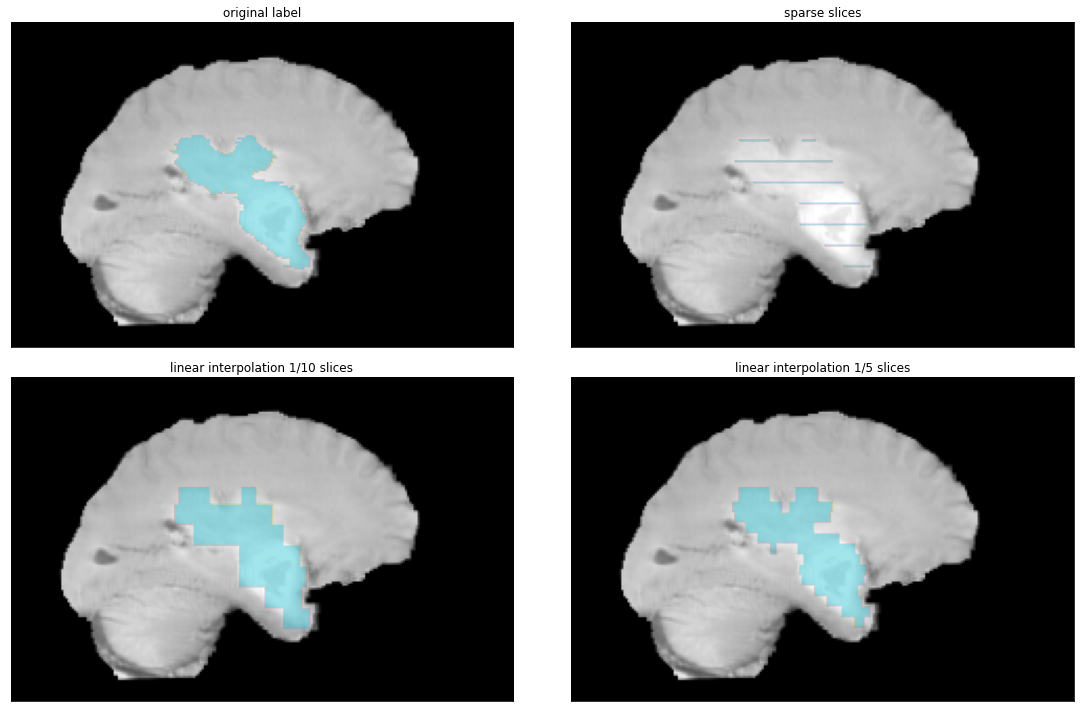

In [158]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
i = 142
axes[0][0].imshow(vol[::-1, i], cmap='gray')
axes[0][0].imshow(lbl[::-1, i], alpha=lbl[::-1, i]*0.4, cmap='tab10')
axes[0][0].set_xticks([])
axes[0][0].set_yticks([])
axes[0][0].set_title('original label')

axes[0][1].imshow(vol[::-1, i], cmap='gray')
axes[0][1].imshow(lbl_sp[::-1, i], alpha=lbl_sp[::-1, i]*0.4, cmap='tab10')
axes[0][1].set_xticks([])
axes[0][1].set_yticks([])
axes[0][1].set_title('sparse slices')

axes[1][0].imshow(vol[::-1, i], cmap='gray')
axes[1][0].imshow(lbl_ln[::-1, i], alpha=lbl_ln[::-1, i]*0.4, cmap='tab10')
axes[1][0].set_xticks([])
axes[1][0].set_yticks([])
axes[1][0].set_title('linear interpolation 1/10 slices')

axes[1][1].imshow(vol[::-1, i], cmap='gray')
axes[1][1].imshow(lbl_ln5[::-1, i], alpha=lbl_ln5[::-1, i]*0.4, cmap='tab10')
axes[1][1].set_xticks([])
axes[1][1].set_yticks([])
axes[1][1].set_title('linear interpolation 1/5 slices')

plt.tight_layout()
plt.show()

In [105]:
len(ids_to_labels)

23

In [102]:
np.mean(shapes, 0), np.mean(slices_filled)

(array([2109.        ,  561.29032258,  537.67741935]), 352.48387096774195)

In [92]:
np.unique(lbl)

array([0, 1, 2, 3, 4, 5])

In [88]:
overall_slices = []
segmented_slices = []

for cid in tqdm(train_ids):
    for lbl_addr in ids_to_labels[cid]:
        lbl = np.vectorize(converter.get)(imread(lbl_addr))
        overall_slices.append(lbl.shape[0])
        segmented_slices.append((lbl.sum((1,2)) > 0).sum(0))
print(np.sum(overall_slices), np.sum(segmented_slices))

  0%|          | 0/18 [00:00<?, ?it/s]

53407 9022


In [23]:
a = tifffile.imread('/mnt/LSDF/projects/code-vita/Medaka/2018_11/Medaka_406_131-4_large/slices.tif')

In [26]:
len(tifffile.TiffFile('/mnt/LSDF/projects/code-vita/Medaka/2018_11/Medaka_406_131-4_large/slices.tif').pages)

6982

In [24]:
a.shape

(982, 2016, 2016)

In [20]:
imread('/mnt/data/decathlon/Task11_Xenopus/test/labels/st01.tif').dtype

dtype('bool')

In [16]:
marked_slices, all_slices = 0, 0
for fn in tqdm(glob(os.path.join(task_addr, 'train', 'labels', '*')), leave=False):
    lbl = imread(os.path.join(task_addr, 'labelsTr', fn))
    marked_slices += (lbl.sum((1, 2)) > 0).sum()
    all_slices += lbl.shape[0]
print(task_addr, marked_slices, all_slices)

  0%|          | 0/16 [00:00<?, ?it/s]

/mnt/data/decathlon/Task11_Xenopus/ 15880 16454


In [94]:
import json
from collections import defaultdict

In [150]:
values_distributions = defaultdict(list)
for task_addr in tqdm(good_tasks[:1]):
    with open(task_addr+'dataset.json') as f:
        modalities = json.load(f)['modality']
    for img_addr in tqdm(glob(task_addr+'imagesTr/*')[:10], leave=False):
        img = imread(img_addr)
        if len(modalities) > 1:
            for i in range(img.shape[-1]):
                values_distributions[modalities[str(i)]+'_'+task_addr.split('/')[-2]].append(img[..., i].flatten())
        else:
            values_distributions[modalities['0']+'_'+task_addr.split('/')[-2]].append(img.flatten())

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

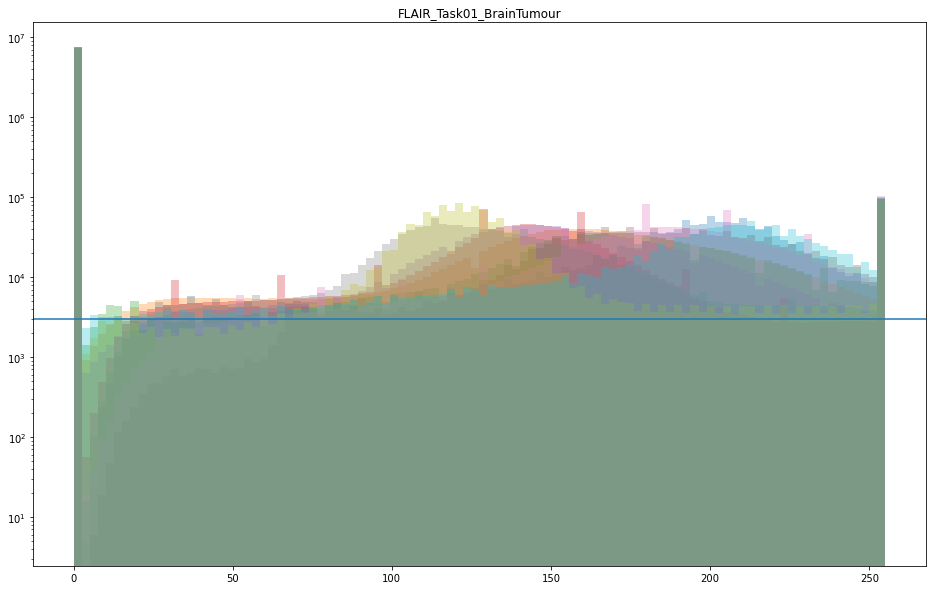

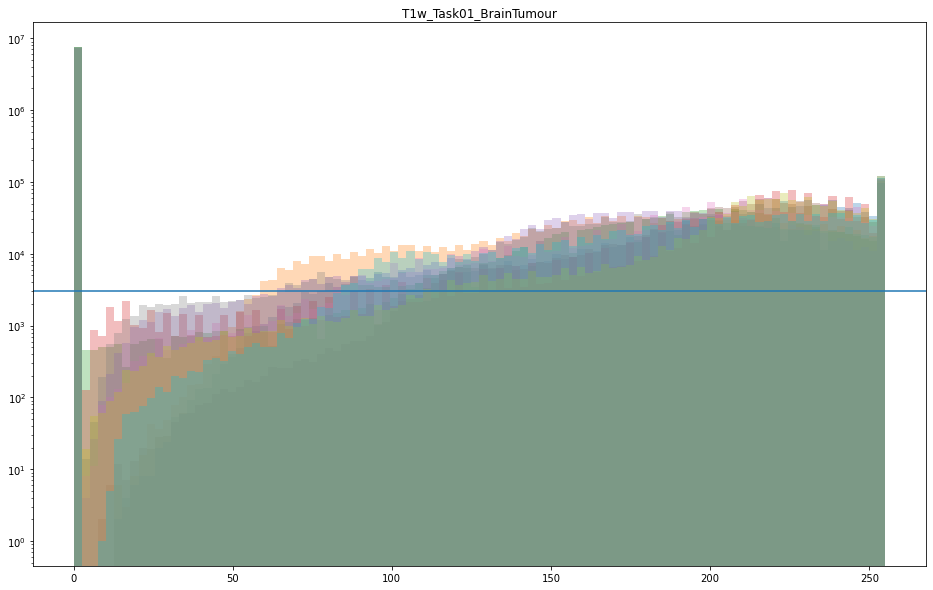

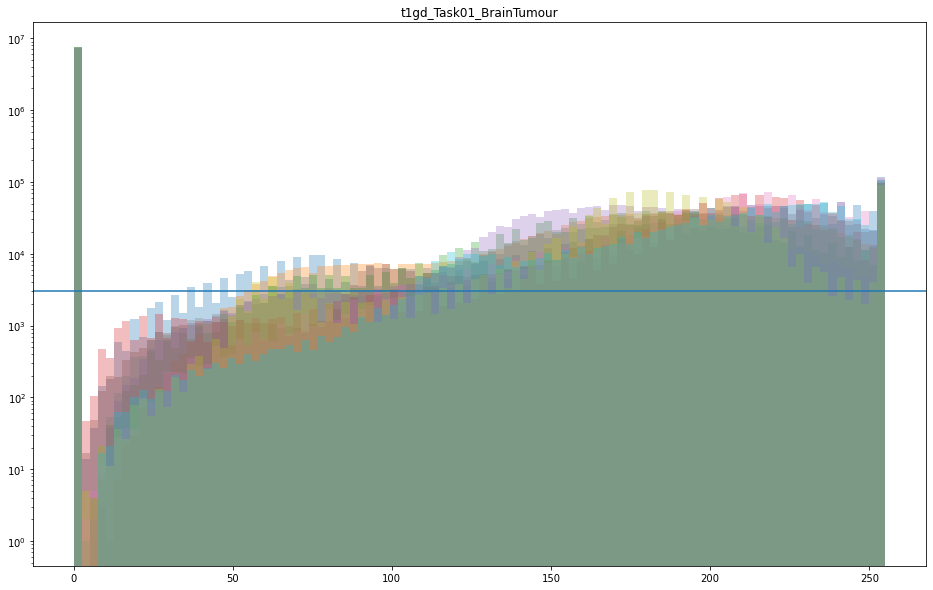

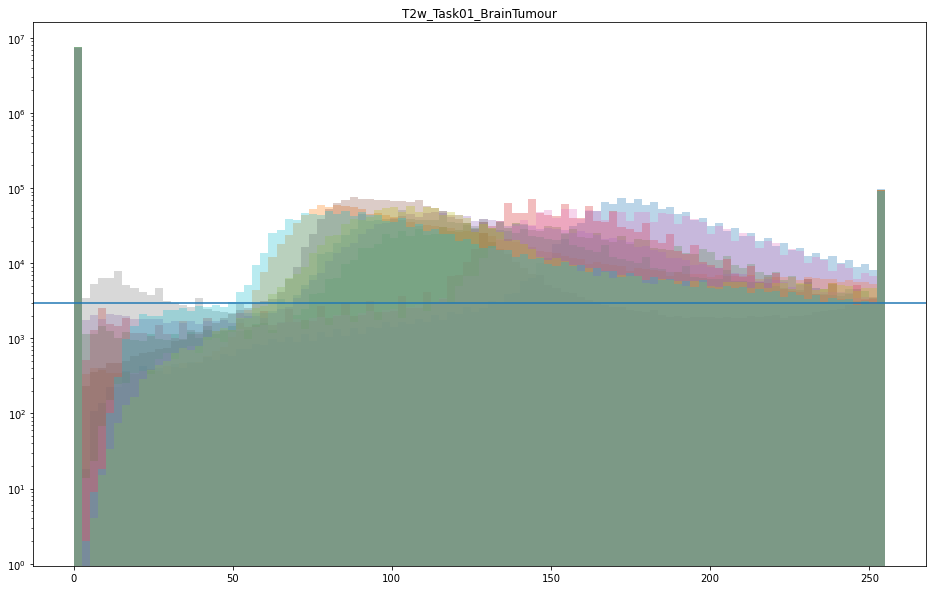

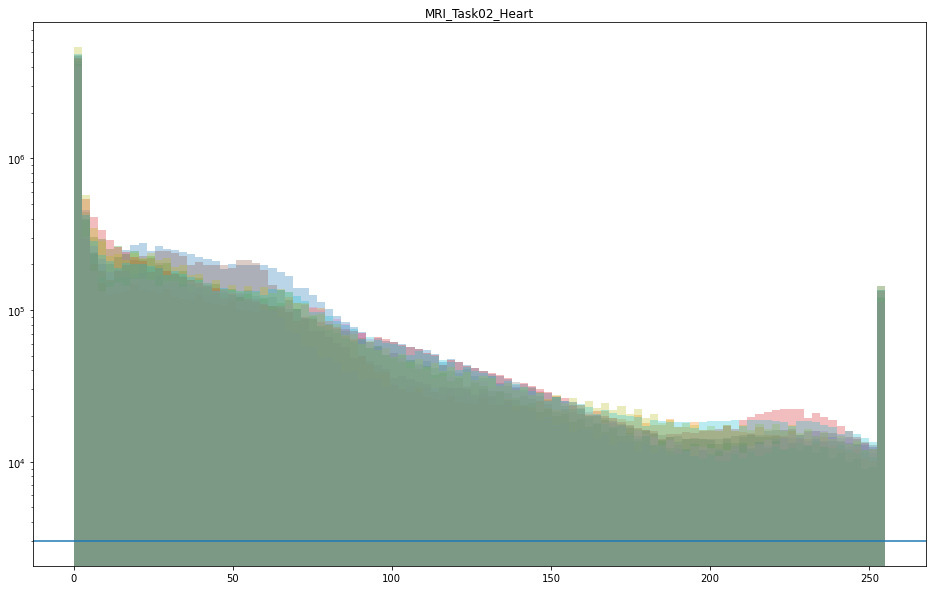

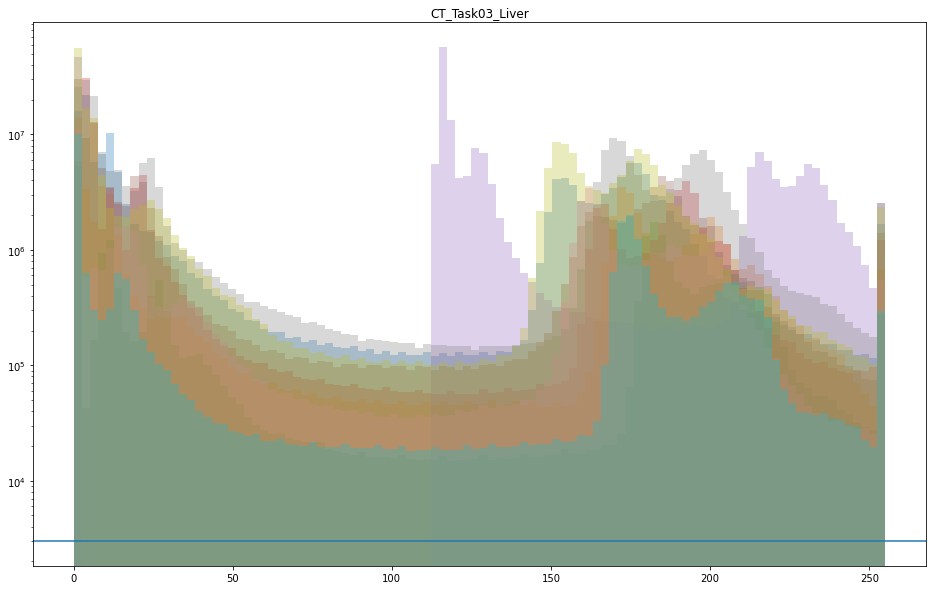

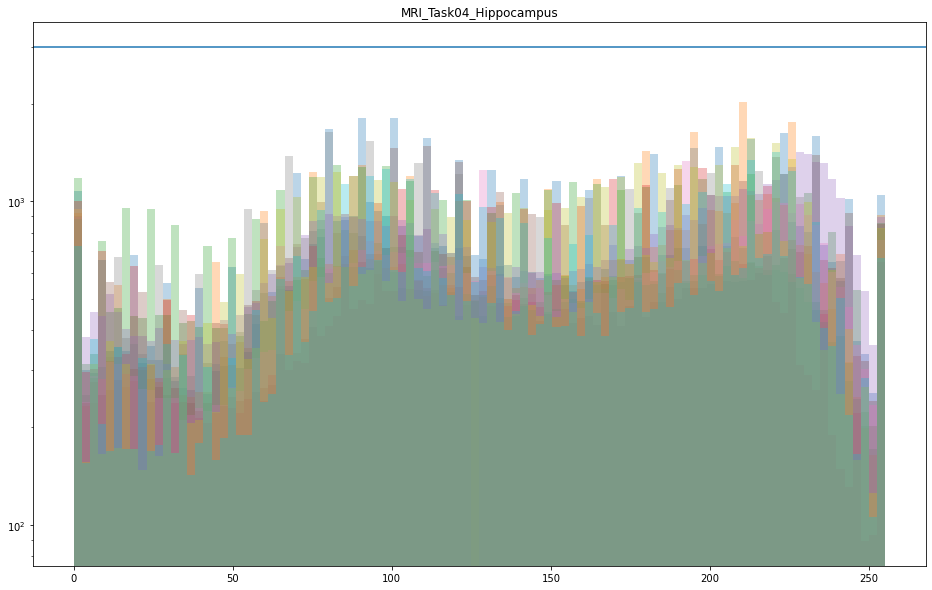

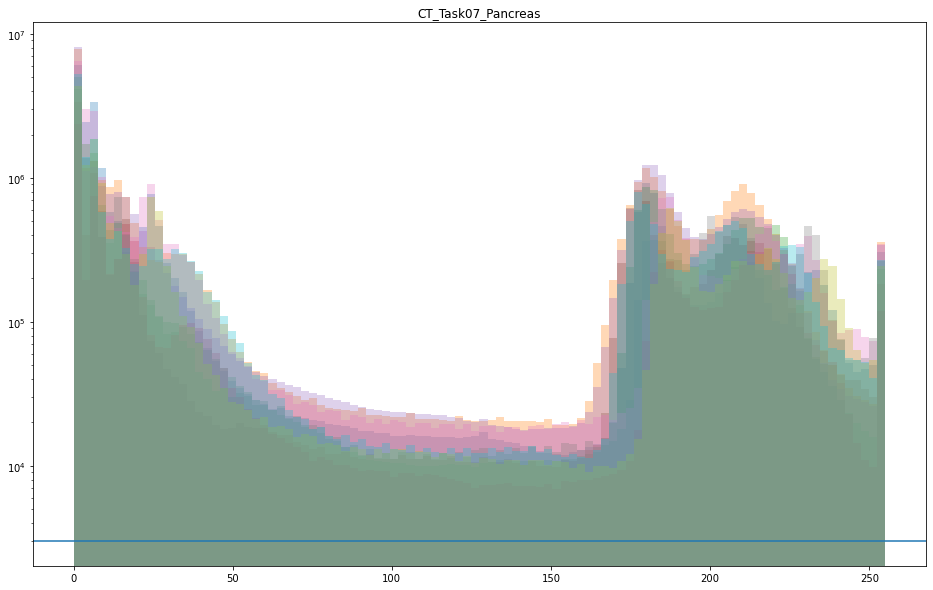

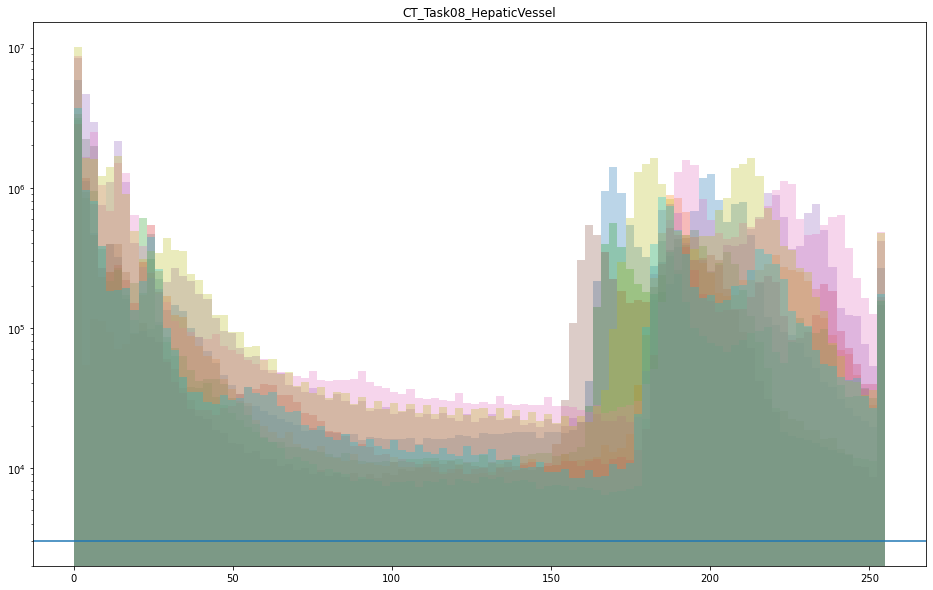

In [138]:
for modality, values in values_distributions.items():
    plt.figure(figsize=(16, 10))
    for v in values:
#         if modality.startswith(tuple(special_thresholds.keys())):
#             inr = (special_thresholds[modality.split('_')[0]][0], special_thresholds[modality.split('_')[0]][1])
#         else:
#             inr = (0, 1200)
        inr = (np.percentile(v, 1), np.percentile(v, 99))

        mv = rescale_intensity(v, 
                               in_range=inr, 
                               out_range=(0, 255))
        plt.hist(mv, bins=100, alpha=0.3, log=True)
    plt.title(modality)
    plt.axhline(3000)
    

    plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

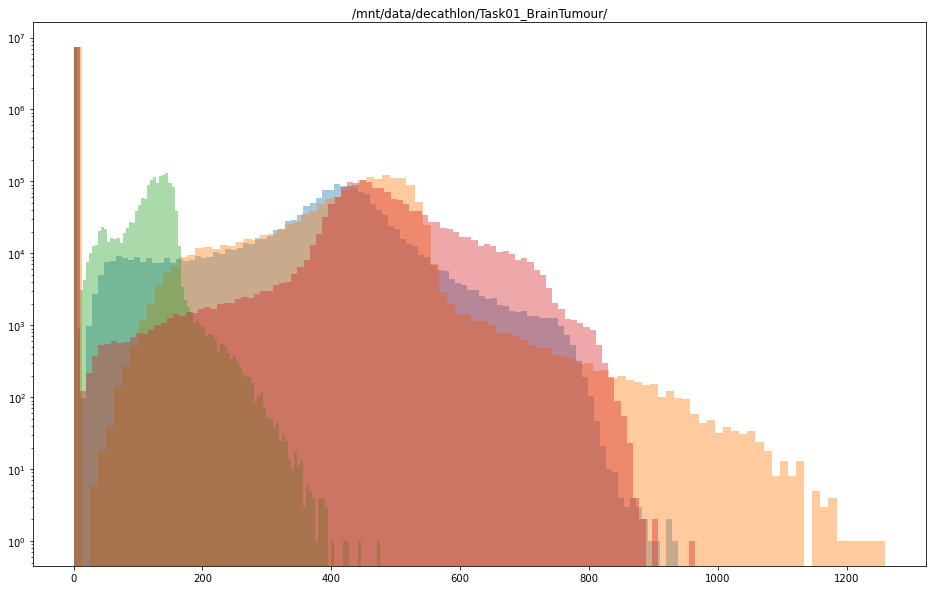

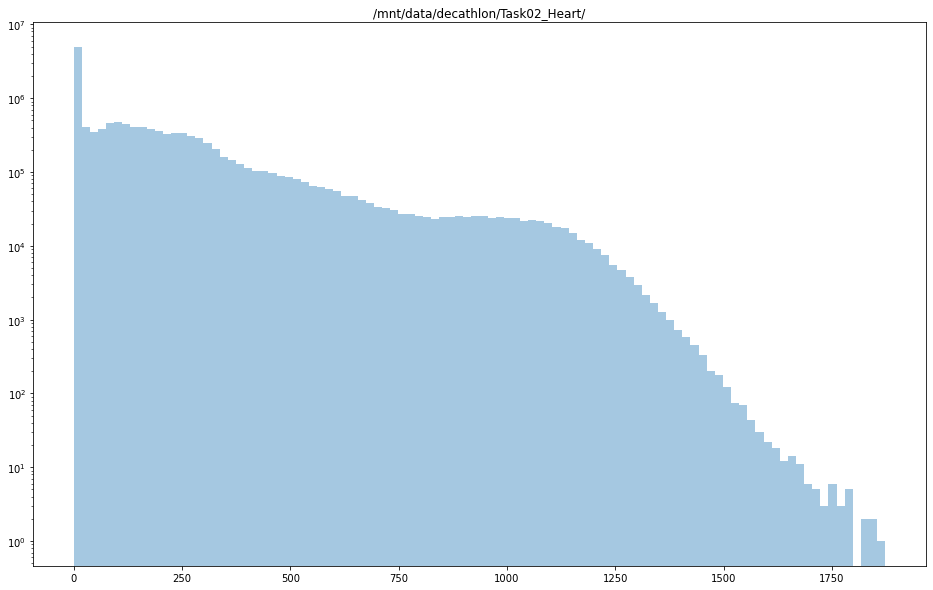

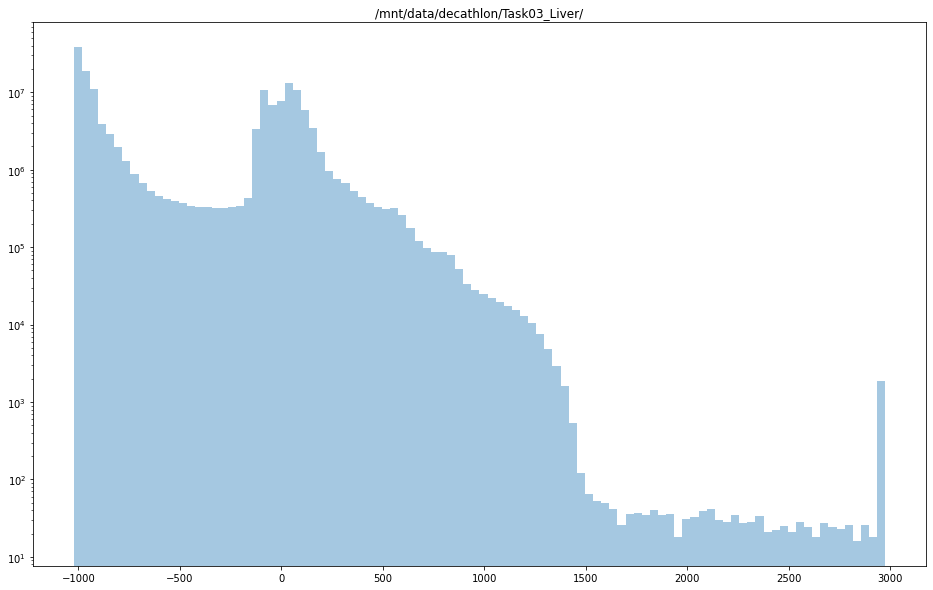

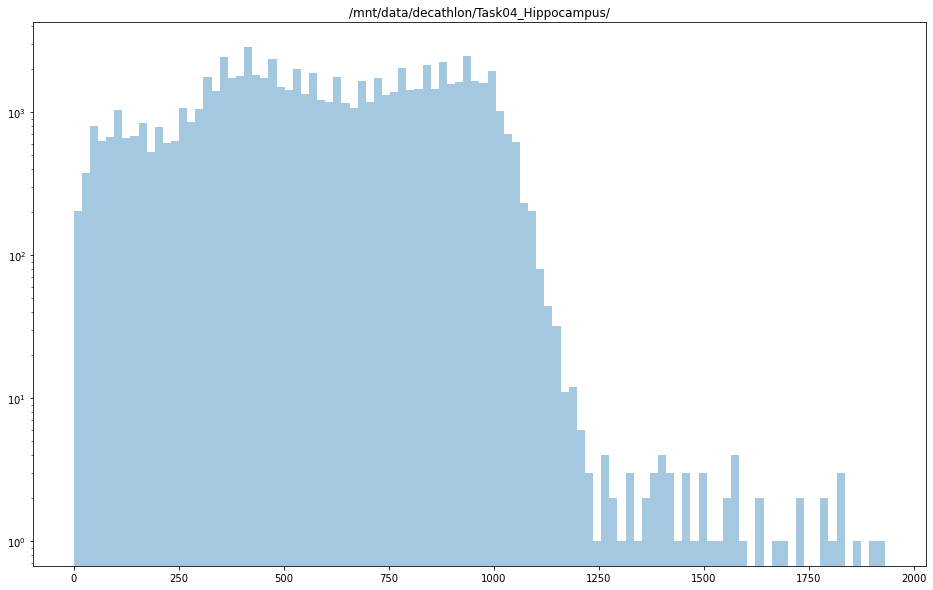

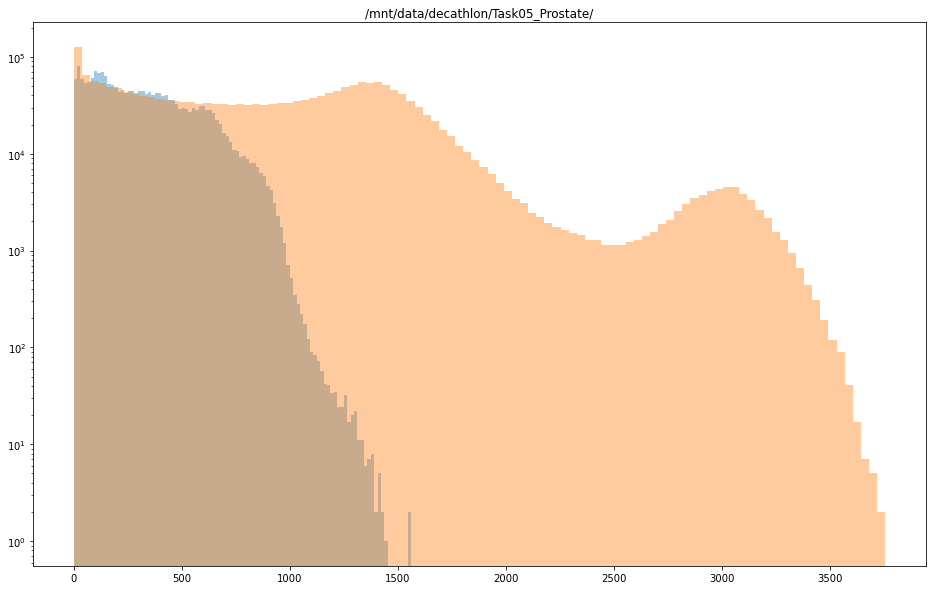

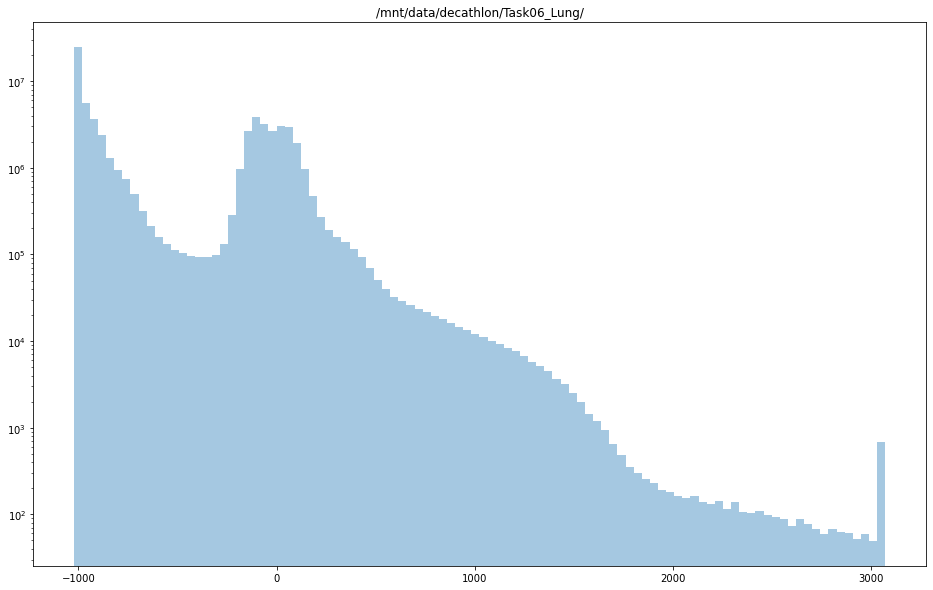

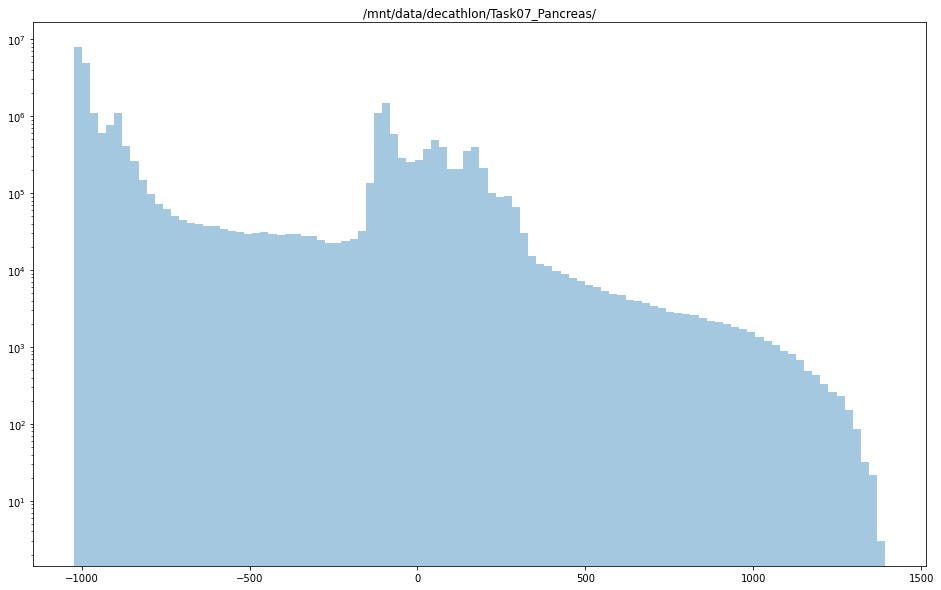

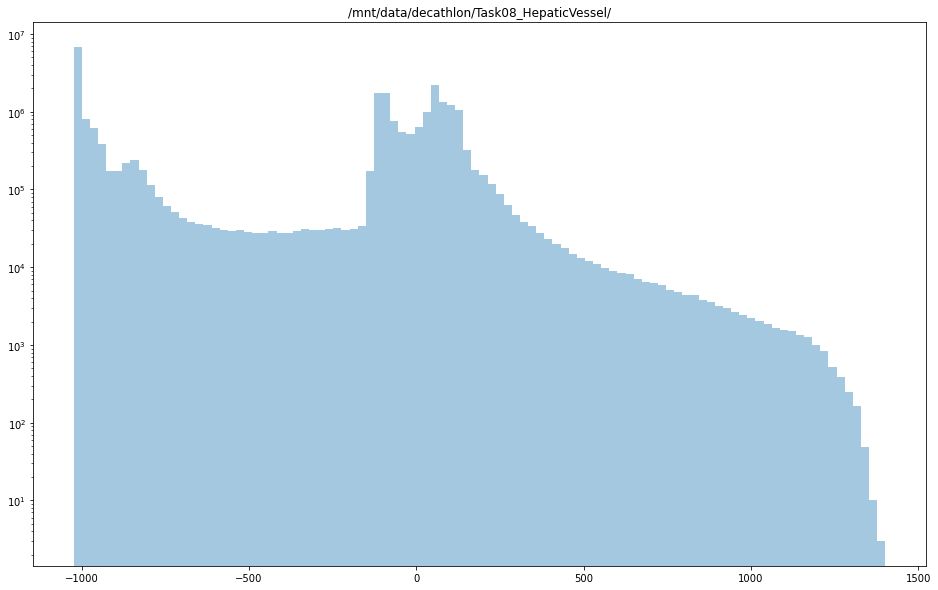

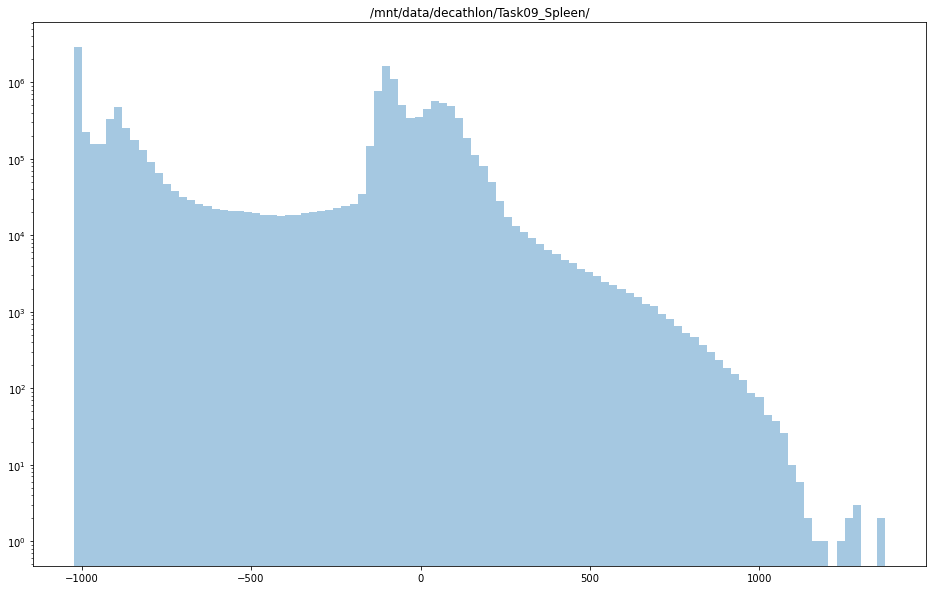

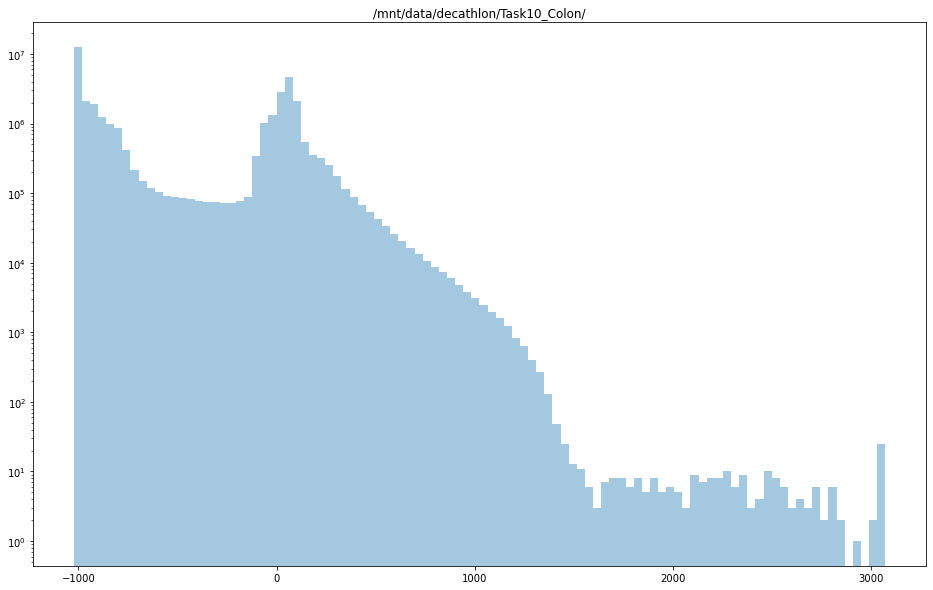

In [66]:
for task_addr in tqdm(tasks):
    img = imread(glob(task_addr+'imagesTr/*')[0])
    
    plt.figure(figsize=(16, 10))
    if len(img.shape) == 3:
        plt.hist(img.flatten(), bins=100, alpha=0.4, log=True)
    else:
        for i in range(img.shape[-1]):
            plt.hist(img[..., i].flatten(), bins=100, alpha=0.4, log=True)
    plt.title(task_addr)
    plt.show()

In [3]:
data_information = {}

for task_addr in tqdm(tasks[1:]):
    shapes_img = []
    shapes_lbl = []
    sizes_lbl = []
    volumes_lbl = []
    
    for img_addr in tqdm(glob(task_addr+'imagesTr/*')[:2], leave=False):
        img = imread(img_addr)
        lbl_addr = task_addr+'labelsTr/'+os.path.basename(img_addr)
        lbl = imread(lbl_addr)
        shapes_img.append(img.shape)
        shapes_lbl.append(lbl.shape)
        
        sizes_lbl.append(((lbl.sum((1, 2))>0).sum(), (lbl.sum((0, 2))>0).sum(), (lbl.sum((1, 0))>0).sum()))
        volumes_lbl.append(np.unique(lbl, return_counts=True)[1]/np.prod(lbl.shape))
    break
    
    data_information[os.path.basename(task_addr[:-1])] = {'shapes_img': shapes_img, 
                                                          'shapes_lbl': shapes_lbl, 
                                                          'sizes_lbl': sizes_lbl, 
                                                          'volumes_lbl': volumes_lbl}

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
import pandas as pd

In [5]:
for experiment, parameters in data_information.items():
    print(experiment, ':', len(parameters['shapes_img']))
    print('--', 'slice side', np.array(parameters['shapes_img']).mean(0)[0])
    print('--', 'for 5', (np.array(parameters['sizes_lbl'])[:, 2]>10).mean(0))
    print('--', 'for 10', (np.array(parameters['sizes_lbl'])[:, 2]>20).mean(0))
    print('--', 'for 20', (np.array(parameters['sizes_lbl'])[:, 2]>40).mean(0))
#     for parameter, description in parameters.items():
#         try:
#             print('--', parameter, (np.array(description)[:, 2]>10).mean(0))
#         except Exception as e:
#             print('--', parameter, e)

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

In [13]:
lbl = np.moveaxis(lbl, -1, 0)
img = np.moveaxis(img, -1, 0)

In [14]:
slbl = get_subsampled_dataset(lbl, 10)

In [15]:
prd = complicated_interpolation(slbl)

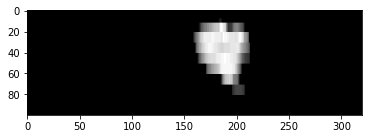

In [16]:
plt.imshow(prd.sum(1), cmap='gray')
plt.show()

In [17]:
import tempfile
import tifffile
import sys

In [42]:
interpolate_with_biomedisa(img, slbl, 'aux.tiff')

ips-deepl 0
Indices: [[9, 16, 26, 36, 46, 56, 66, 76, 82]]
ips-deepl 0: 1/2
ips-deepl 0: 2/2
Walktime_ips-deepl 0: 24 seconds
Computation time: 25 sec


In [43]:
prd_bm = imread('aux.tiff')

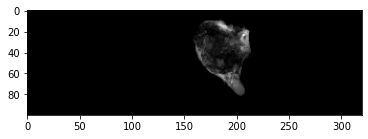

In [44]:
plt.imshow((prd_bm-lbl).sum(1), cmap='gray')
plt.show()

In [34]:
ls /tmp

krb5cc_11671
krb5cc_232269
krb5ccmachine_BWSERVICES.UNI-HEIDELBERG.DE
pyright-1261906-Cv26520O6ajp/
pyright-1261906-Z9kNjTZQwckJ/
pyright-1606511-n5kCPHcfk011/
pyright-1606626-yTC2f5Rl8FO5/
pyright-3623052-u6NWBzsucO0B/
pyright-3628842-nHh9HAPi3to2/
pyright-4118733-JTrKCCdP21wq/
pyright-556989-w5X8ytJGHIVD/
pyright-67637-EL9RkbHEjDs0/
pyright-96750-V1oTuNl4UPuN/
python-languageserver-cancellation/
systemd-private-22920695c35a4672ba30d0667fabbd57-chrony.service-NVbyEg/
systemd-private-22920695c35a4672ba30d0667fabbd57-ModemManager.service-5m0rog/
systemd-private-22920695c35a4672ba30d0667fabbd57-systemd-logind.service-nrNjci/
systemd-private-22920695c35a4672ba30d0667fabbd57-systemd-resolved.service-YYBVog/
tmp4_p1ky0bwandb-media/
tmp5re_fib4wandb-media/
tmpeqywf2p0wandb-media/
tmpf0yonmz8wandb/
tmph25gqs9xwandb/
tmp_p22ljd4wandb-artifacts/
tmpthtv96bswandb-media/
tmpu4qqqi3qwandb-artifacts/
tmpvdd1o2howandb/
tmux-232269/


In [30]:
rm /tmp/*.tiff

In [21]:
from matplotlib import pyplot as plt
%matplotlib inline

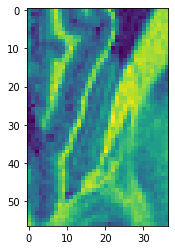

In [47]:
plt.imshow(img[10])

In [221]:
a = {'train': [('/mnt/data/decathlon/Task02_Heart/train/images_sparse/la_030.tif', '/mnt/data/decathlon/Task02_Heart/train/labels_sparse/la_030.tif'), ('/mnt/data/decathlon/Task02_Heart/train/images_sparse/la_014.tif', '/mnt/data/decathlon/Task02_Heart/train/labels_sparse/la_014.tif'), ('/mnt/data/decathlon/Task02_Heart/train/images_sparse/la_011.tif', '/mnt/data/decathlon/Task02_Heart/train/labels_sparse/la_011.tif'), ('/mnt/data/decathlon/Task02_Heart/train/images_sparse/la_026.tif', '/mnt/data/decathlon/Task02_Heart/train/labels_sparse/la_026.tif'), ('/mnt/data/decathlon/Task02_Heart/train/images_sparse/la_022.tif', '/mnt/data/decathlon/Task02_Heart/train/labels_sparse/la_022.tif'), ('/mnt/data/decathlon/Task02_Heart/train/images_sparse/la_021.tif', '/mnt/data/decathlon/Task02_Heart/train/labels_sparse/la_021.tif'), ('/mnt/data/decathlon/Task02_Heart/train/images_sparse/la_010.tif', '/mnt/data/decathlon/Task02_Heart/train/labels_sparse/la_010.tif'), ('/mnt/data/decathlon/Task02_Heart/train/images_sparse/la_023.tif', '/mnt/data/decathlon/Task02_Heart/train/labels_sparse/la_023.tif'), ('/mnt/data/decathlon/Task02_Heart/train/images_sparse/la_009.tif', '/mnt/data/decathlon/Task02_Heart/train/labels_sparse/la_009.tif'), ('/mnt/data/decathlon/Task02_Heart/train/images_sparse/la_029.tif', '/mnt/data/decathlon/Task02_Heart/train/labels_sparse/la_029.tif'), ('/mnt/data/decathlon/Task02_Heart/train/images_sparse/la_005.tif', '/mnt/data/decathlon/Task02_Heart/train/labels_sparse/la_005.tif'), ('/mnt/data/decathlon/Task02_Heart/train/images_sparse/la_018.tif', '/mnt/data/decathlon/Task02_Heart/train/labels_sparse/la_018.tif')], 'valid': [('/mnt/data/decathlon/Task02_Heart/train/images_sparse/la_003.tif', '/mnt/data/decathlon/Task02_Heart/train/labels_sparse/la_003.tif'), ('/mnt/data/decathlon/Task02_Heart/train/images_sparse/la_017.tif', '/mnt/data/decathlon/Task02_Heart/train/labels_sparse/la_017.tif'), ('/mnt/data/decathlon/Task02_Heart/train/images_sparse/la_016.tif', '/mnt/data/decathlon/Task02_Heart/train/labels_sparse/la_016.tif'), ('/mnt/data/decathlon/Task02_Heart/train/images_sparse/la_020.tif', '/mnt/data/decathlon/Task02_Heart/train/labels_sparse/la_020.tif')], 'infer': [('/mnt/data/decathlon/Task02_Heart/test/volumes/la_007.tif', '/mnt/data/decathlon/Task02_Heart/test/labels/la_007.tif'), ('/mnt/data/decathlon/Task02_Heart/test/volumes/la_024.tif', '/mnt/data/decathlon/Task02_Heart/test/labels/la_024.tif'), ('/mnt/data/decathlon/Task02_Heart/test/volumes/la_004.tif', '/mnt/data/decathlon/Task02_Heart/test/labels/la_004.tif'), ('/mnt/data/decathlon/Task02_Heart/test/volumes/la_019.tif', '/mnt/data/decathlon/Task02_Heart/test/labels/la_019.tif')]}
b = {'train': [('/mnt/data/decathlon/Task02_Heart/train/images_sparse/la_030.tif', '/mnt/data/decathlon/Task02_Heart/train/labels_sparse/la_030.tif'), ('/mnt/data/decathlon/Task02_Heart/train/images_sparse/la_014.tif', '/mnt/data/decathlon/Task02_Heart/train/labels_sparse/la_014.tif'), ('/mnt/data/decathlon/Task02_Heart/train/images_sparse/la_011.tif', '/mnt/data/decathlon/Task02_Heart/train/labels_sparse/la_011.tif'), ('/mnt/data/decathlon/Task02_Heart/train/images_sparse/la_026.tif', '/mnt/data/decathlon/Task02_Heart/train/labels_sparse/la_026.tif'), ('/mnt/data/decathlon/Task02_Heart/train/images_sparse/la_022.tif', '/mnt/data/decathlon/Task02_Heart/train/labels_sparse/la_022.tif'), ('/mnt/data/decathlon/Task02_Heart/train/images_sparse/la_021.tif', '/mnt/data/decathlon/Task02_Heart/train/labels_sparse/la_021.tif'), ('/mnt/data/decathlon/Task02_Heart/train/images_sparse/la_010.tif', '/mnt/data/decathlon/Task02_Heart/train/labels_sparse/la_010.tif'), ('/mnt/data/decathlon/Task02_Heart/train/images_sparse/la_023.tif', '/mnt/data/decathlon/Task02_Heart/train/labels_sparse/la_023.tif'), ('/mnt/data/decathlon/Task02_Heart/train/images_sparse/la_009.tif', '/mnt/data/decathlon/Task02_Heart/train/labels_sparse/la_009.tif'), ('/mnt/data/decathlon/Task02_Heart/train/images_sparse/la_029.tif', '/mnt/data/decathlon/Task02_Heart/train/labels_sparse/la_029.tif'), ('/mnt/data/decathlon/Task02_Heart/train/images_sparse/la_005.tif', '/mnt/data/decathlon/Task02_Heart/train/labels_sparse/la_005.tif'), ('/mnt/data/decathlon/Task02_Heart/train/images_sparse/la_018.tif', '/mnt/data/decathlon/Task02_Heart/train/labels_sparse/la_018.tif')], 'valid': [('/mnt/data/decathlon/Task02_Heart/train/images_sparse/la_003.tif', '/mnt/data/decathlon/Task02_Heart/train/labels_sparse/la_003.tif'), ('/mnt/data/decathlon/Task02_Heart/train/images_sparse/la_017.tif', '/mnt/data/decathlon/Task02_Heart/train/labels_sparse/la_017.tif'), ('/mnt/data/decathlon/Task02_Heart/train/images_sparse/la_016.tif', '/mnt/data/decathlon/Task02_Heart/train/labels_sparse/la_016.tif'), ('/mnt/data/decathlon/Task02_Heart/train/images_sparse/la_020.tif', '/mnt/data/decathlon/Task02_Heart/train/labels_sparse/la_020.tif')], 'infer': [('/mnt/data/decathlon/Task02_Heart/test/volumes/la_007.tif', '/mnt/data/decathlon/Task02_Heart/test/labels/la_007.tif'), ('/mnt/data/decathlon/Task02_Heart/test/volumes/la_024.tif', '/mnt/data/decathlon/Task02_Heart/test/labels/la_024.tif'), ('/mnt/data/decathlon/Task02_Heart/test/volumes/la_004.tif', '/mnt/data/decathlon/Task02_Heart/test/labels/la_004.tif'), ('/mnt/data/decathlon/Task02_Heart/test/volumes/la_019.tif', '/mnt/data/decathlon/Task02_Heart/test/labels/la_019.tif')]}


In [217]:
import os

In [222]:
for k, v in a.items():
    print(k, sorted([os.path.basename(vi[0]) for vi in v]))

train ['la_005.tif', 'la_009.tif', 'la_010.tif', 'la_011.tif', 'la_014.tif', 'la_018.tif', 'la_021.tif', 'la_022.tif', 'la_023.tif', 'la_026.tif', 'la_029.tif', 'la_030.tif']
valid ['la_003.tif', 'la_016.tif', 'la_017.tif', 'la_020.tif']
infer ['la_004.tif', 'la_007.tif', 'la_019.tif', 'la_024.tif']


In [223]:
for k, v in b.items():
    print(k, sorted([os.path.basename(vi[0]) for vi in v]))

train ['la_005.tif', 'la_009.tif', 'la_010.tif', 'la_011.tif', 'la_014.tif', 'la_018.tif', 'la_021.tif', 'la_022.tif', 'la_023.tif', 'la_026.tif', 'la_029.tif', 'la_030.tif']
valid ['la_003.tif', 'la_016.tif', 'la_017.tif', 'la_020.tif']
infer ['la_004.tif', 'la_007.tif', 'la_019.tif', 'la_024.tif']
